<a href="https://colab.research.google.com/github/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/10_explaining_logistic_regression_classifier_and_RNN_model_using_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining a logistic regression classifier and RNN model using shap

Consider a scenario where we developed a classifier that identifies abusive comments on a discussion forum website. The classifier identifies comments that are objectionable/abusive and performs the job of a human moderator by either deleting them or making them invisible to users. We know that classifiers aren’t perfect and can make errors. 

**What if the commenter questions this moderation decision and asks for an
explanation?**

Some method to “explain” the classification decision by pointing to which feature’s presence prompted such a decision can be useful in such cases. Such a
method is also useful to provide some insights into the model and how it may perform on real-world data (instead of train/test sets), which may result in better, more reliable models in the future.

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

<img src='https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png?raw=1' width='800'/>



Let’s now look at how [Shap](https://shap.readthedocs.io/en/latest/) can be used to explan the predictions of a text classifier.

## Setup

This notebook demonstrates model explainability using [shap](https://shap.readthedocs.io/en/latest/). Firstly we will look at explaining Classical ML models then move on to a RNN model. 

In [13]:
%%shell

pip install shap

Setup for logistic regression classifier.

In [14]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.linear_model import LogisticRegression

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#import time function from time module to track the training duration
from time import time

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import shap

from pprint import pprint

Setup for LSTM model training.

In [15]:
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
import re
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant
import tensorflow as tf
from tensorflow import keras

from keras.datasets import imdb

## Part 1: Training and evaluating logistic regression classifier 

We will be using a similar model to the one on [Statistical Text Classification with Naive Bayes, Logistic Regression and SVM](https://github.com/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/1_statistical_text_classification_with_naive_bayes_logistic_regression_and_svm.ipynb) notebook.


In [ ]:
our_data = pd.read_csv("https://query.data.world/s/yd24ckbjzyp7h6zp7bacafpv2lgfkh" , encoding = "ISO-8859-1" )

display(our_data.shape) #Number of rows (instances) and columns in the dataset
display(our_data["relevance"].value_counts()/our_data.shape[0])#Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [ ]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape

(7991, 15)

In [ ]:
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] #Let us take only the two columns we need.
our_data.shape

(7991, 2)

In [ ]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

In [ ]:
#Step 1: train-test split
X = our_data.text #the column text contains textual data to extract features from
y = our_data.relevance #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [ ]:
vect = TfidfVectorizer(min_df=5)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
model = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
model.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = model.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

Accuracy:  0.7382382382382382


## Part 2: Explaining Classifier Predictions with Shap

Let’s take a model we already built and see how Shap can help us interpret its predictions.

In [ ]:
explainer = shap.LinearExplainer(model, X_train_dtm, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_dtm)

# we need to pass a dense version for the plotting functions
X_test_array = X_test_dtm.toarray()
pprint(our_data["text"][0])

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


('NEW YORK -- Yields on most certificates of deposit offered by major banks '
 'dropped more than a tenth of a percentage point in the latest week, '
 'reflecting the overall decline in short-term interest rates.</br></br>On '
 'small-denomination, or "consumer," CDs sold directly by banks, the average '
 'yield on six-month deposits fell to 5.49% from 5.62% in the week ended '
 'yesterday, according to an 18-bank survey by Banxquote Money Markets, a '
 'Wilmington, Del., information service.</br></br>On three-month "consumer" '
 'deposits, the average yield sank to 5.29% from 5.42% the week before, '
 'according to Banxquote. Two banks in the Banxquote survey, Citibank in New '
 'York and CoreStates in Pennsylvania, are paying less than 5% on threemonth '
 'small-denomination CDs.</br></br>Declines were somewhat smaller on five-year '
 'consumer CDs, which eased to 7.37% from 7.45%, Banxquote '
 'said.</br></br>Yields on three-month and six-month Treasury bills sold at '
 "Monday's au

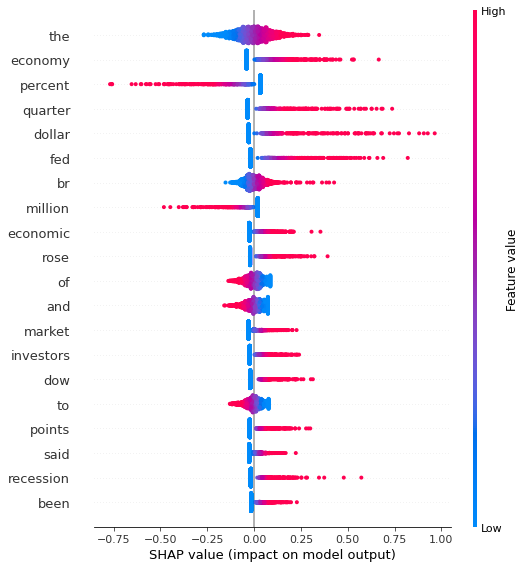

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names())

The SHAP value plot can further show the positive and negative relationships of the predictors with the target variable.

This plot is made of all the dots in the train data. It demonstrates the following information:

1. **Feature importance**: Variables are ranked in descending order from the most important decreasing to the least.
2. **Impact**: The horizontal location shows what effect the fature has with respect to prediction (higher or lower prediction).
3. **Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation.
4. **Correlation**: The presence of the word "dollar" has a high (positive) impact in deciding whether the article is relavent to the USA economy.

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_array[0, :], feature_names=vect.get_feature_names())

Let me describe this elegant plot in great detail: The output value is the prediction for that observation (the prediction of the first row in Table B is 6.20).

1. **The base value**: The [original paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat).
2. **Red/blue**: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
3. **Economy**: Has a positive impact on deciding if the article is relavent for US Economy. So it pushes the prediction to the right.

## Part 3: Training and evaluating LSTM model

In [16]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [17]:
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train,test = download_and_load_datasets()

In [18]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0}

In [19]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)

trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])

x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Found 88582 unique tokens.
Splitting the train data into train and valid is done


In [20]:
batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly

print("Defining and training an LSTM model, training embedding layer on the fly")
#modified from: 
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(2, activation='sigmoid'))
rnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Training the RNN')
rnnmodel.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Defining and training an LSTM model, training embedding layer on the fly
Training the RNN
Epoch 1/2
625/625 [==============================] - 991s 2s/step - loss: 0.4719 - accuracy: 0.7830 - val_loss: 0.3867 - val_accuracy: 0.8374
Epoch 2/2
625/625 [==============================] - 1003s 2s/step - loss: 0.2665 - accuracy: 0.8990 - val_loss: 0.3272 - val_accuracy: 0.8600


In [21]:
score, acc = rnnmodel.evaluate(test_data, test_labels, batch_size=32)
print('Test accuracy with RNN:', acc)

782/782 [==============================] - 199s 255ms/step - loss: 0.3311 - accuracy: 0.8585
Test accuracy with RNN: 0.858519971370697


## Part 4: Explaining LSTM model using shap

In [25]:
x_val[:5]

array([[    0,     0,     0, ...,   173,     4,   209],
       [    0,     0,     0, ...,   964,   467,   155],
       [    0,     0,     0, ...,     1, 17221,  1695],
       [    0,     0,     0, ...,    28,     5,   794],
       [    0,     0,     0, ...,    69,     3,    62]], dtype=int32)

In [ ]:
shap.initjs()

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(rnnmodel, x_train[:20])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_val)

words = imdb.get_word_index()
num2word = {}
for w in words.keys():
  num2word[words[w]] = w
x_val_words = np.stack([np.array(list(map(lambda x: num2word.get(x, None), x_val[i]))) for i in range(10)])

In [ ]:
# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_val_words[0])

Note that each sample is an IMDB review, represented as a sequence of words. This means "feature 0" is the first word in the review, which will be different for difference reviews.

This means calling summary_plot will combine the importance of all the words by their position in the text. This is likely not what you want for a global measure of feature importance (which is why we have not called summary_plot here). If you do want a global summary of a word's importance you could pull apart the feature attribution values and group them by words.


There are many more amazing plots in SHAP which you can use to explain your model. You can find all of them at SHAP's [github page](https://github.com/slundberg/shap).